In [20]:
#imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree

%matplotlib inline

# Column names from the word document "Network Anamoly Detection" for the dataset
column_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
"wrong_fragment","urgent","hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate", "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

dataset = pd.read_csv("../Data/Train.txt", names=column_names)
dataset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [21]:
# Removing rows with no values in them
print("shape pre-dropna:", dataset.shape)
dataset.dropna(inplace=True)
print("shape post-dropna:", dataset.shape)

shape pre-dropna: (125973, 43)
shape post-dropna: (125973, 43)


In [22]:
# Giving the categories in the nominal features a separate column each with binarY/boolean values
temp = pd.get_dummies(dataset[['protocol_type', 'service', 'flag']]).astype('int')
# Replaces three features with eighty-four features boolean
print("Features created from 'protocol_type', 'service', and 'flag':", temp.shape)

# Getting the attack classes from the dataset
attack_classes = dataset.attack
attack_classes_dummy = pd.get_dummies(dataset['attack']).astype('int')

# Giving each attack a different integer value
def mapping(val):
    class_mapping = [
        {'value_string': "normal",'value_int': 0},
        {'value_string': "back",'value_int': 1},
        {'value_string': "land",'value_int': 2},
        {'value_string': "neptune",'value_int': 3},
        {'value_string': "pod",'value_int': 4},
        {'value_string': "smurf",'value_int': 5},
        {'value_string': "teardrop",'value_int': 6},
        {'value_string': "apache2",'value_int': 7},
        {'value_string': "udpstorm",'value_int': 8},
        {'value_string': "processtable",'value_int': 9},
        {'value_string': "worm",'value_int': 10},
        
        {'value_string': "satan",'value_int': 11},
        {'value_string': "ipsweep",'value_int': 12},
        {'value_string': "nmap",'value_int': 13},
        {'value_string': "portsweep",'value_int': 14},
        {'value_string': "mscan",'value_int': 15},
        {'value_string': "saint",'value_int': 16},
        
        {'value_string': "guess_passwd",'value_int': 17},
        {'value_string': "ftp_write",'value_int': 18},
        {'value_string': "imap",'value_int': 19},
        {'value_string': "phf",'value_int': 20},
        {'value_string': "multihop",'value_int': 21},
        {'value_string': "warezmaster",'value_int': 22},
        {'value_string': "warezclient",'value_int': 23},
        {'value_string': "spy",'value_int': 24},
        {'value_string': "xlock",'value_int': 25},
        {'value_string': "xsnoop",'value_int': 26},
        {'value_string': "snmpguess",'value_int': 27},
        {'value_string': "snmpgetattack",'value_int': 28},
        {'value_string': "httptunnel",'value_int': 29},
        {'value_string': "sendmail",'value_int': 30},
        {'value_string': "named",'value_int': 31},
        
        {'value_string': "buffer_overflow",'value_int': 32},
        {'value_string': "loadmodule",'value_int': 33},
        {'value_string': "rootkit",'value_int': 34},
        {'value_string': "perl",'value_int': 35},
        {'value_string': "sqlattack",'value_int': 36},
        {'value_string': "xterm",'value_int': 37},
        {'value_string': "ps",'value_int': 38},
    ]
    for class_map in class_mapping:
        if val == class_map['value_string']:
            return class_map['value_int']
attack_classes_int = attack_classes.apply(mapping)

# Dropping the independent variable 'attack' and the columns 'protocol_type', 'service', and 'flag' 
temporary_dataset = dataset.drop(['attack', 'protocol_type', 'service', 'flag'], axis=1).astype('float64')
new_dataset = pd.concat([temporary_dataset, temp], axis=1)

print("New dataset's shape:", new_dataset.shape)
new_dataset.head()

Features created from 'protocol_type', 'service', and 'flag': (125973, 84)
New dataset's shape: (125973, 123)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,491.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,232.0,8153.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,199.0,420.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0


### Eliminating highly correlated features.

num_compromised and num_root are highly correlated (0.9988334525784719)
num_root and num_compromised are highly correlated (0.9988334525784719)
serror_rate and srv_serror_rate are highly correlated (0.9932892425370415)
serror_rate and dst_host_serror_rate are highly correlated (0.9793730829843228)
serror_rate and dst_host_srv_serror_rate are highly correlated (0.9811389586179857)
serror_rate and flag_S0 are highly correlated (0.9791740914923958)
srv_serror_rate and serror_rate are highly correlated (0.9932892425370415)
srv_serror_rate and dst_host_serror_rate are highly correlated (0.9775960119654394)
srv_serror_rate and dst_host_srv_serror_rate are highly correlated (0.9862517164930875)
srv_serror_rate and flag_S0 are highly correlated (0.9826599622600537)
rerror_rate and srv_rerror_rate are highly correlated (0.9890076529820739)
rerror_rate and dst_host_rerror_rate are highly correlated (0.9267485035759243)
rerror_rate and dst_host_srv_rerror_rate are highly correlated (0.96444866550

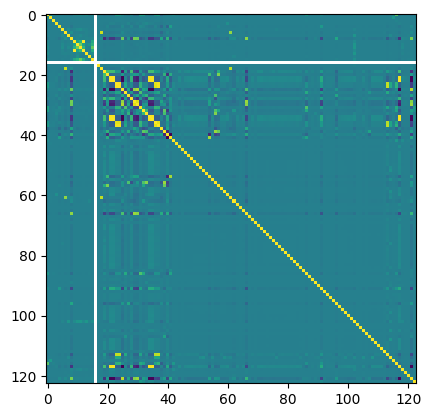

[[1.0, 0.07073682819085414, 0.03487779833437003, -0.0015532805525947443, -0.009865808515815139, 0.003829897181915918, 0.000705120566211187, 0.009528249936349882, -0.06421767647301116, 0.042679474817442095, 0.052790950792928525, 0.08718341292134439, 0.045519157361409816, 0.09911569750163096, -0.0015934673468352128, 0.07041992093460996, nan, -0.00025761943672739616, 0.0004402248819930365, -0.07904231889655419, -0.03947023790265667, -0.06987295957015192, -0.06951028293813129, 0.2006819844142431, 0.19996108167067075, 0.07468058598343401, -0.01373757895926031, -0.04015809532609311, 0.05057003428877992, -0.109775561199984, -0.11600495557790014, 0.2541951745852428, 0.2287373765622746, -0.026669376728929953, -0.06494796244229974, -0.06436051447487312, 0.1738152898998144, 0.19902360421159065, -0.15631061303783145, -0.029263345542364316, -0.004642982519098148, 0.027974374377361635, 0.09319418730832142, 0.0037412564778459014, -0.007744632866980154, -0.0004392939757158932, -0.008205440388428653, -

In [23]:
result = []
for columnx in new_dataset.columns:
    resulting_row = []
    for columny in new_dataset.columns:
        correlation = new_dataset[columnx].corr(new_dataset[columny])
        if (columnx != columny) and ((correlation > 0.9) or (correlation < -0.9)):
            print(f"{columnx} and {columny} are highly correlated ({correlation})")
        resulting_row.append(correlation)
    result.append(resulting_row)

plt.imshow(result)
plt.show()

print(result)

From the results above we can see that the following features are highly correlated:
* num_compromised and num_root
* serror_rate, srv_serror_rate, dst_host_serror_rate, dst_host_srv_serror_rate, and flag_S0
* rerror_rate, srv_rerror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate

Therefore the remaining features will be (as the rest will be dropped):
* num_root
* serror_rate
* rerror_rate

In [24]:
# Dropping the features:
# num_compromised,
# srv_serror_rate, dst_host_serror_rate, dst_host_srv_serror_rate, flag_S0,
# srv_rerror_rate, dst_host_rerror_rate, and dst_host_srv_rerror_rate 
print("pre:", new_dataset.shape)
features_droppping = ['num_compromised',
                      'srv_serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'flag_S0',
                      'srv_rerror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
new_dataset = new_dataset.drop(features_droppping, axis=1).astype('float64')
print("post:", new_dataset.shape)

pre: (125973, 123)
post: (125973, 115)


### Feature importance

In [25]:
dataset_train, dataset_test, value_train, value_test = train_test_split(new_dataset, attack_classes_int)

forest = RandomForestClassifier(random_state=0)
forest.fit(dataset_train, value_train)

RandomForestClassifier(random_state=0)

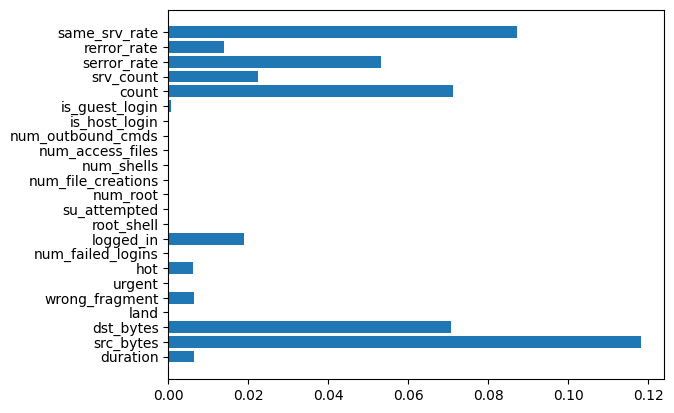

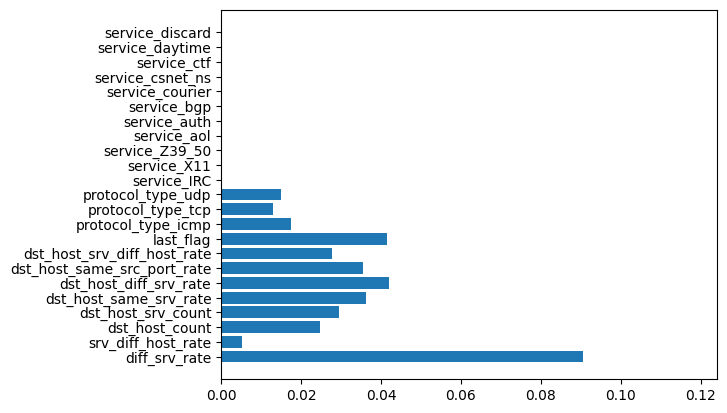

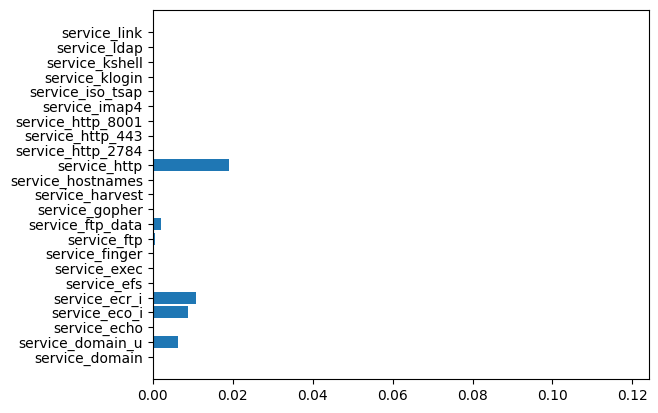

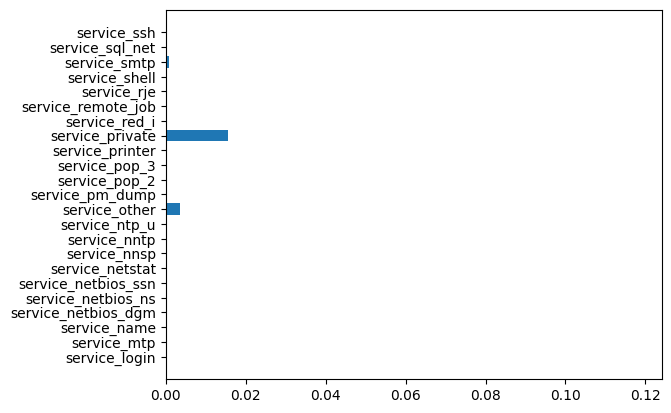

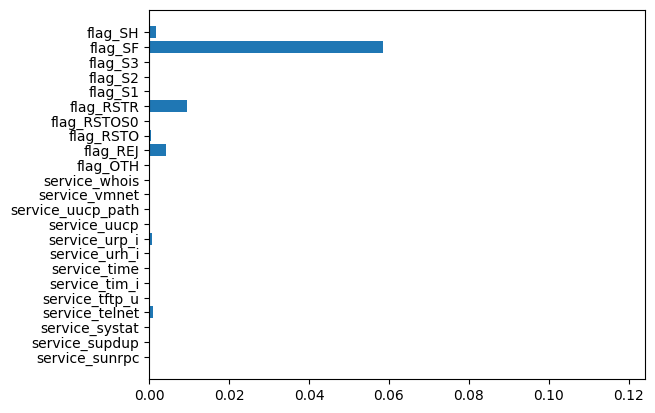

In [26]:
highest_value = max(forest.feature_importances_)
split_columns = np.array_split(new_dataset.columns, 5)
split_importances = np.array_split(forest.feature_importances_, 5)
for index in range(len(split_columns)):
    plt.barh(split_columns[index], split_importances[index])
    plt.xlim(0, highest_value + (highest_value*0.05))
    plt.show()


In [27]:
forest_importances = pd.Series(forest.feature_importances_, index=([x for x in dataset_train.columns]))
print("Number of important features:", len(forest_importances[forest_importances > 0.01]))
forest_importances.nlargest(len(forest_importances[forest_importances > 0.01]))

Number of important features: 23


src_bytes                      0.118168
diff_srv_rate                  0.090514
same_srv_rate                  0.087095
count                          0.071156
dst_bytes                      0.070593
flag_SF                        0.058390
serror_rate                    0.053221
dst_host_diff_srv_rate         0.042026
last_flag                      0.041497
dst_host_same_srv_rate         0.036263
dst_host_same_src_port_rate    0.035486
dst_host_srv_count             0.029439
dst_host_srv_diff_host_rate    0.027633
dst_host_count                 0.024728
srv_count                      0.022431
service_http                   0.019064
logged_in                      0.018818
protocol_type_icmp             0.017437
service_private                0.015584
protocol_type_udp              0.014962
rerror_rate                    0.014039
protocol_type_tcp              0.012873
service_ecr_i                  0.010869
dtype: float64

In [28]:
# print(len(forest.estimators_))
# print(forest.estimators_)
# tree.plot_tree(forest.estimators_[0])

Correct predictions: 31466
Incorrect predictions: 28
Total samples: 31494
Accuracy score: 0.9991109417666857


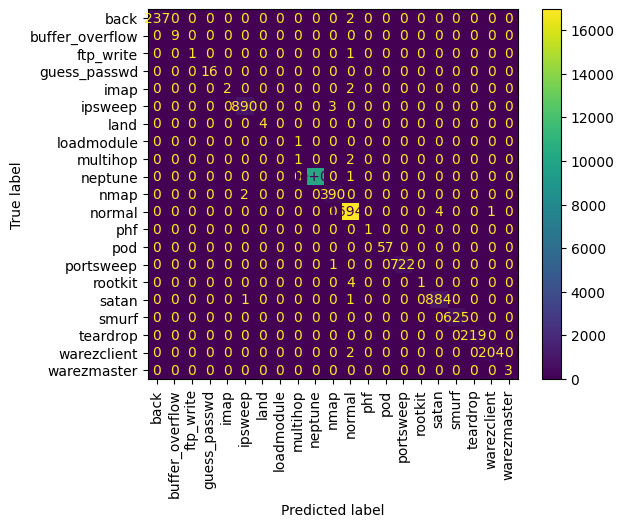

In [29]:
attacks = ["normal", "back", "land", "neptune", "pod", "smurf", "teardrop", "apache2", "udpstorm", "processtable",
 "worm", "satan", "ipsweep", "nmap", "portsweep", "mscan", "saint", "guess_passwd", "ftp_write", "imap",
 "phf", "multihop", "warezmaster", "warezclient", "spy", "xlock", "xsnoop", "snmpguess", "snmpgetattack",
 "httptunnel", "sendmail", "named", "buffer_overflow", "loadmodule", "rootkit", "perl", "sqlattack", 
 "xterm","ps"]

predicted_attacks = []
actual_attacks = []

for val in value_test:
    actual_attacks.append(attacks[val])
for predicted_val in forest.predict(dataset_test):
    predicted_attacks.append(attacks[predicted_val])

display = ConfusionMatrixDisplay.from_predictions(actual_attacks, predicted_attacks, xticks_rotation=90)

correct_predictions = 0
for index in range(len(display.confusion_matrix)):
    correct_predictions += display.confusion_matrix[index][index]
print("Correct predictions:", correct_predictions)
print("Incorrect predictions:", len(value_test) - correct_predictions)
print("Total samples:", len(value_test))
print("Accuracy score:", correct_predictions/len(value_test))

# Correct predictions: 31457
# Incorrect predictions: 37
# Total samples: 31494
# Accuracy score: 0.9988251730488347

Making a new random forest model with the features having a variable importance over 0.01

In [30]:
important_features = forest_importances.nlargest(len(forest_importances[forest_importances > 0.01]))
new_forest = RandomForestClassifier(random_state=0)
new_forest.fit(dataset_train[important_features.index], value_train)



RandomForestClassifier(random_state=0)

In [31]:
# print(len(new_forest.estimators_))
# print(new_forest.estimators_)
# tree.plot_tree(new_forest.estimators_[0])

In [32]:
scores = cross_val_score(new_forest, new_dataset, attack_classes_int, scoring="accuracy", cv=10)
print("Mean score:", np.mean(scores))
print("Max score:", np.max(scores))
print("Min score:", np.min(scores))
print("Standard deviation:", np.std(scores))
print("Standard variance:", np.var(scores))

print("--------------------")
cross_val_forest = RandomForestClassifier(random_state=0)
scores = cross_val_score(cross_val_forest, new_dataset, attack_classes_int, scoring="accuracy", cv=10)
print("Mean score:", np.mean(scores))
print("Max score:", np.max(scores))
print("Min score:", np.min(scores))
print("Standard deviation:", np.std(scores))
print("Standard variance:", np.var(scores))

/home/khalidium/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Mean score: 0.9989759756400194
Max score: 0.9995236961181234
Min score: 0.9987299571360534
Standard deviation: 0.00022576631954476475
Standard variance: 5.097043104078882e-08
--------------------


/home/khalidium/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Mean score: 0.9989759756400194
Max score: 0.9995236961181234
Min score: 0.9987299571360534
Standard deviation: 0.00022576631954476475
Standard variance: 5.097043104078882e-08


: 

Correct predictions: 31456
Incorrect predictions: 38
Total samples: 31494
Accuracy score: 0.9987934209690734


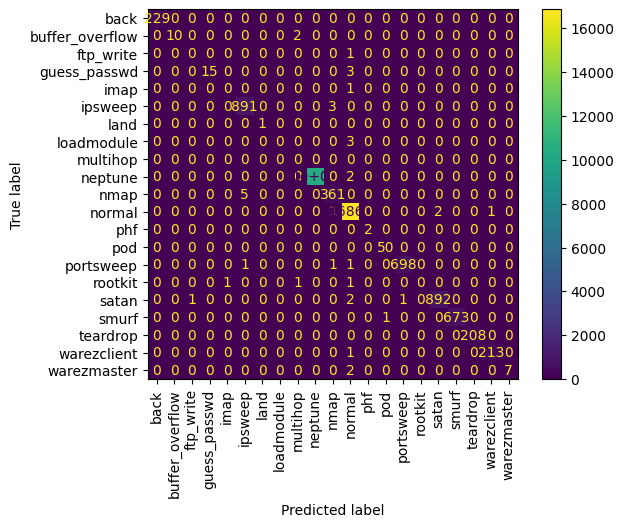

In [14]:
attacks = ["normal", "back", "land", "neptune", "pod", "smurf", "teardrop", "apache2", "udpstorm", "processtable",
 "worm", "satan", "ipsweep", "nmap", "portsweep", "mscan", "saint", "guess_passwd", "ftp_write", "imap",
 "phf", "multihop", "warezmaster", "warezclient", "spy", "xlock", "xsnoop", "snmpguess", "snmpgetattack",
 "httptunnel", "sendmail", "named", "buffer_overflow", "loadmodule", "rootkit", "perl", "sqlattack", 
 "xterm","ps"]

predicted_attacks = []
actual_attacks = []

for val in value_test:
    actual_attacks.append(attacks[val])
for predicted_val in new_forest.predict(dataset_test[important_features.index]):
    predicted_attacks.append(attacks[predicted_val])

display = ConfusionMatrixDisplay.from_predictions(actual_attacks, predicted_attacks, xticks_rotation=90)

correct_predictions = 0
for index in range(len(display.confusion_matrix)):
    correct_predictions += display.confusion_matrix[index][index]
print("Correct predictions:", correct_predictions)
print("Incorrect predictions:", len(value_test) - correct_predictions)
print("Total samples:", len(value_test))
print("Accuracy score:", correct_predictions/len(value_test))

Interesting observation, reducing the features with high correlation improved the accuracy but using the features with a high variable importance and eliminating features with low variable importance didn't change the accuracy from much. (improved the interpretability but not the accuracy (which was unlikely since the accuracy already was a 99.99)) 

### ROC curve

In [15]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
# train_probability = new_forest.predict_proba(dataset_train[important_features.index])[:, 1]
# test_probability = new_forest.predict_proba(dataset_test[important_features.index])[:, 1]

# # false_positive_rate_train, true_positive_rate_train, _ = roc_curve(value_train, train_probability)
# # false_positive_rate_test, true_positive_rate_test, _ = roc_curve(value_test, test_probability)

# value_train_binarized = label_binarize(value_train)
# false_positive_rate_train, true_positive_rate_train, _ = roc_curve(value_train, train_probability)
# false_positive_rate_test, true_positive_rate_test, _ = roc_curve(value_test, test_probability)

# # roc_auc_train = roc_auc_score(value_train, train_probability)
# # roc_auc_test = roc_auc_score(value_test, test_probability)
# roc_auc_train = 0
# roc_auc_test = 0

# ax1.plot(false_positive_rate_train, true_positive_rate_train, label="ROC curve (Area = %0.2f)" % roc_auc_train)
# ax2.plot(false_positive_rate_test, true_positive_rate_test, label="ROC curve (Area = %0.2f)" % roc_auc_test)
# ax1.set_title("ROC on training data")
# ax2.set_title("ROC on test data")
# ax1.legend(loc="lower right")
# ax2.legend(loc="lower right")

# # plt.show()
# for axises in fig.axes:
#     axises.plot([0,1], [0,1], 'k--')
#     axises.set_xlim([-0.05, 1])
#     axises.set_ylim([0, 1.05])
    
#     axises.set_xlabel("False positive rate")
#     axises.set_ylabel("True positive rate")

In [16]:
# attacks = ["normal", "back", "land", "neptune", "pod", "smurf", "teardrop", "apache2", "udpstorm", "processtable",
#  "worm", "satan", "ipsweep", "nmap", "portsweep", "mscan", "saint", "guess_passwd", "ftp_write", "imap",
#  "phf", "multihop", "warezmaster", "warezclient", "spy", "xlock", "xsnoop", "snmpguess", "snmpgetattack",
#  "httptunnel", "sendmail", "named", "buffer_overflow", "loadmodule", "rootkit", "perl", "sqlattack", 
#  "xterm","ps"]
# for index, label in enumerate()
#     sensitivity = display.confusion_matrix[index][index] / np.sum(display.confusion_matrix[index][:])
#     print("Sensitivity:", sensitivity)
#     specificity = (np.sum(display.confusion_matrix[1:, 0:1]) + np.sum(display.confusion_matrix[1:, 2:])) / (np.sum(display.confusion_matrix[0:, 0:1]) + np.sum(display.confusion_matrix[0:, 2:]))
#     print("Specificity DOS:", specificity_dos)

# # sensitivity_dos = display.confusion_matrix[0][0] / np.sum(display.confusion_matrix[0][:])
# # sensitivity_normal = display.confusion_matrix[1][1] / np.sum(display.confusion_matrix[1][:])
# # sensitivity_probing = display.confusion_matrix[2][2] / np.sum(display.confusion_matrix[2][:])
# # sensitivity_r2l = display.confusion_matrix[3][3] / np.sum(display.confusion_matrix[3][:])
# # sensitivity_u2r = display.confusion_matrix[4][4] / np.sum(display.confusion_matrix[4][:])

# # print("Sensitivity DOS:", sensitivity_dos)
# # print("Sensitivity Normal:", sensitivity_normal)
# # print("Sensitivity Probing:", sensitivity_probing)
# # print("Sensitivity R2L:", sensitivity_r2l)
# # print("Sensitivity U2R:", sensitivity_u2r)

# # specificity_dos = np.sum(display.confusion_matrix[1:,1:]) / np.sum(display.confusion_matrix[0:,1:])
# # specificity_normal = (np.sum(display.confusion_matrix[1:, 0:1]) + np.sum(display.confusion_matrix[1:, 2:])) / (np.sum(display.confusion_matrix[0:, 0:1]) + np.sum(display.confusion_matrix[0:, 2:]))
# # specificity_probing = (np.sum(display.confusion_matrix[1:, 0:2]) + np.sum(display.confusion_matrix[1:, 3:])) / (np.sum(display.confusion_matrix[0:, 0:2]) + np.sum(display.confusion_matrix[0:, 3:]))
# # specificity_r2l = (np.sum(display.confusion_matrix[1:, 0:3]) + np.sum(display.confusion_matrix[1:, 4:])) / (np.sum(display.confusion_matrix[0:, 0:3]) + np.sum(display.confusion_matrix[0:, 4:]))
# # specificity_u2r = (np.sum(display.confusion_matrix[1:, 0:4]) + np.sum(display.confusion_matrix[1:, 5:])) / (np.sum(display.confusion_matrix[0:, 0:4]) + np.sum(display.confusion_matrix[0:, 5:]))

# # print("Specificity DOS:", specificity_dos)
# # print("Specificity Normal:", specificity_normal)
# # print("Specificity Probing:", specificity_probing)
# # print("Specificity R2L:", specificity_r2l)
# # print("Specificity U2R:", specificity_u2r)


# # this is intrusion detection, use accuraxy and false positive rate!!!!

In [17]:
# accuracies = []
# for index in range(len(important_features.index)):
#     temp_forest = RandomForestClassifier(random_state=0)
#     temp_forest.fit(dataset_train[important_features.index[0:(index+1)]], value_train)
#     scores = cross_val_score(temp_forest, dataset_test[important_features.index[0:(index+1)]], value_test, scoring="accuracy", cv=10)
#     print("Mean score:", np.mean(scores))
#     accuracies.append(np.mean(scores))
    
# print(accuracies)
# plt.plot(range(len(accuracies)+1), [0] + accuracies)
# plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], 
#            labels=['src_bytes', '& diff_srv_rate', '& same_srv_rate', '& count', '& flag_SF',
#                    'dst_bytes', '& serror_rate', '& dst_host_diff_srv_rate',
#                    'dst_host_same_src_port_rate', '& last_flag', '& dst_host_srv_count',
#                    'dst_host_same_srv_rate', '& dst_host_count',
#                    'dst_host_srv_diff_host_rate', '& srv_count', '& protocol_type_icmp',
#                    'rerror_rate', '& service_http', '& service_ecr_i', '& logged_in',
#                    'service_private', '& service_eco_i', '& protocol_type_tcp', '& protocol_type_udp', ''], 
#            rotation="vertical")
# plt.show()

In [18]:
# false_positive_rate_test, true_positive_rate_test, _ = roc_curve(value_test, test_probability, pos_label=1)
# print(np.mean(false_positive_rate_test)*100)
print(np.mean(cross_val_score(new_forest, dataset_test[important_features.index], value_test, scoring="f1_macro", cv=10)))

/home/khalidium/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0.8904227910217786


### Test train split hyper parameter adjustment (20%, 25% (done above), 30%)

In [19]:
dataset_train_20, dataset_test_20, value_train_20, value_test_20 = train_test_split(new_dataset, attack_classes_int, test_size=0.20)
dataset_train_30, dataset_test_30, value_train_30, value_test_30 = train_test_split(new_dataset, attack_classes_int, test_size=0.30)
temp_forest_20 = RandomForestClassifier(random_state=0)
temp_forest_20.fit(dataset_train_20[important_features.index], value_train_20)
temp_forest_30 = RandomForestClassifier(random_state=0)
temp_forest_30.fit(dataset_train_30[important_features.index], value_train_30)

scores_20 = cross_val_score(temp_forest_20, dataset_test_20, value_test_20, scoring="accuracy", cv=10)
scores_30 = cross_val_score(temp_forest_30, dataset_test_30, value_test_30, scoring="accuracy", cv=10)
print("Cross validation accuracy (test size: 20%):", np.mean(scores_20))
print("Cross validation standard deviation (test size: 20%):", np.std(scores_20))
print("Cross validation variance (test size: 20%):", np.var(scores_20))

print("Cross validation accuracy (test size: 30%):", np.mean(scores_30))
print("Cross validation standard deviation (test size: 30%):", np.std(scores_30))
print("Cross validation variance (test size: 30%):", np.var(scores_30))

f1_score_20 = np.mean(cross_val_score(temp_forest_20, dataset_test_20, value_test_20, scoring="f1_macro", cv=10))
f1_score_30 = np.mean(cross_val_score(temp_forest_30, dataset_test_30, value_test_30, scoring="f1_macro", cv=10))
print("Cross validation f1-score (test size: 20%):", np.mean(f1_score_20))
print("Cross validation f1-score deviation (test size: 30%):", np.mean(f1_score_30))

confusion_matrix_20 = confusion_matrix(value_test_20, temp_forest_20.predict(dataset_test_20[important_features.index]))
confusion_matrix_30 = confusion_matrix(value_test_30, temp_forest_30.predict(dataset_test_30[important_features.index]))

correct_predictions = 0
for index in range(len(confusion_matrix_20)):
    correct_predictions += confusion_matrix_20[index][index]
print("Confusion matrix accuracy (test size: 20%):", correct_predictions/len(value_test_20))

correct_predictions = 0
for index in range(len(confusion_matrix_30)):
    correct_predictions += confusion_matrix_30[index][index]    
print("Confusion matrix accuracy (test size: 30%):", correct_predictions/len(value_test_30))

/home/khalidium/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/home/khalidium/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Cross validation accuracy (test size: 20%): 0.9975788924806392
Cross validation standard deviation (test size: 20%): 0.0006509478864656745
Cross validation variance (test size: 20%): 4.237331508941287e-07
Cross validation accuracy (test size: 30%): 0.9982271071964112
Cross validation standard deviation (test size: 30%): 0.0006803891656334518
Cross validation variance (test size: 30%): 4.629294167113848e-07


/home/khalidium/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/home/khalidium/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Cross validation f1-score (test size: 20%): 0.8844281596356938
Cross validation f1-score deviation (test size: 30%): 0.8554330782446401
Confusion matrix accuracy (test size: 20%): 0.9986902163127604
Confusion matrix accuracy (test size: 30%): 0.9987298899237934
